# 1. Импорт

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from datetime import datetime
from datetime import timedelta

import re
import math

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

import requests 
from bs4 import BeautifulSoup


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# фиксируем RANDOM_SEED и версию пакетов
RANDOM_SEED = 42
!pip freeze > requirements.txt

# 2. Загрузка и первичный осмотр данных

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
print('df_train')
display(df_train.head(1))
print('df_test')
display(df_test.head(1))
print('sample_submission')
display(sample_submission.head(1))

df_train


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643


df_test


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918


sample_submission


,Restaurant_id,Rating
0,id_0,2.0


In [5]:
# Для того, чтобы обработать признаки в обеих частях (и в тренировочной и тестовой) объединяем эти части в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем наш тест
df_test['Rating'] = 0 # заполняем нулями рейтинг в тестовой части, где его пока нет

# Процесс объединения
data = df_test.append(df_train, sort=False).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Описание признаков:
* **City**: Город 
* **Cuisine Style**: Кухня
* **Ranking**: Ранг ресторана относительно других ресторанов в этом городе
* **Price Range**: Цены в ресторане в 3 категориях
* **Number of Reviews**: Количество отзывов
* **Reviews**: 2 последних отзыва и даты этих отзывов
* **URL_TA**: страница ресторана на 'www.tripadvisor.com' 
* **ID_TA**: ID ресторана в TripAdvisor
* **Rating**: Рейтинг ресторана

In [6]:
# Переименнуем названия колонок в более удобный формат
data.columns = ['_'.join(col.split()).lower() for col in data.columns]
data.columns.tolist()

['restaurant_id',
 'city',
 'cuisine_style',
 'ranking',
 'price_range',
 'number_of_reviews',
 'reviews',
 'url_ta',
 'id_ta',
 'sample',
 'rating']

**Большинство данных "загрязненны", что видно невооруженным взяглядом.**

In [7]:
# выборка случайных 5 строк из массива
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
46578,id_765,Copenhagen,"['Cafe', 'American', 'Danish', 'Vegetarian Fri...",766.0,$$ - $$$,36.0,"[['Nice semi Indian cafe', 'Exellent food and ...",/Restaurant_Review-g189541-d10289994-Reviews-C...,d10289994,1,4.5
40388,id_12603,Paris,NaN,12605.0,NaN,NaN,[['Wuji Douniu - Korean & Chinese Restaurant']...,/Restaurant_Review-g187147-d10778626-Reviews-R...,d10778626,1,3.0
1011,id_1011,Madrid,"['Mediterranean', 'European', 'Spanish', 'Inte...",1788.0,$$ - $$$,113.0,"[['Try the Urugay Steak with Chimichurri', 'Fa...",/Restaurant_Review-g187514-d5501079-Reviews-Ba...,d5501079,0,0.0
3643,id_3643,Milan,"['Pub', 'European']",5753.0,$,36.0,"[['Cozy and easy'], ['11/12/2017']]",/Restaurant_Review-g187849-d3699506-Reviews-He...,d3699506,0,0.0
27295,id_12698,Paris,['Chinese'],12700.0,NaN,14.0,"[['My Chinese canteen'], ['11/11/2016']]",/Restaurant_Review-g187147-d4260849-Reviews-Au...,d4260849,1,3.0


# 3. Очистка данных

## 3.1 Обработка NAN

### Признак number_of_reviews

In [8]:
# Заполним пустые значения "Number of Reviews" нулями, предварительно вынесем пустые данные в отдельный столбец
# Заполнять пропуски другими признаками не считаю целесообразным, т.к. это может испортить общее восприятие данных
data['num_of_rev_nan'] = pd.isna(data['number_of_reviews']).astype('uint8')
data['number_of_reviews'].fillna(0, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    50000 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
num_of_rev_nan       50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(1)
memory usage: 4.2+ MB


### Признак price_range

In [10]:
data.price_range.value_counts(ascending=False)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [11]:
data[data.price_range.isna()].restaurant_id.count()

17361

Видим, что очень много пропущенных значений.  
Заменим пропуски средним значением

In [12]:
data.price_range = data.price_range.fillna(value='$$ - $$$')

### Признак reviews

In [13]:
data.reviews.value_counts().head()

[[], []]                                                                                                             8112
[['Very average food. Over average prices.', 'great food with great service!'], ['11/17/2017', '08/17/2017']]           2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                        2
[['Good restaurant for one meal.', 'Olive Garden Restaurant Warsaw. Food very...'], ['04/20/2015', '07/15/2013']]       2
[['Excellent cuisine, friendly and helpful se...', 'Not tasty'], ['12/25/2016', '06/05/2016']]                          2
Name: reviews, dtype: int64

Очень много строк имеют значение [[], []], такие значени необходимо заменить на nan

In [14]:
data.reviews = data.reviews.apply(lambda x: np.nan if x == '[[], []]' else x)
data.reviews = data.reviews.fillna(value = '-')

In [15]:
# Вынесем пустые данные в отдельный столбец
data['reviews_nan'] = pd.isna(data['reviews']).astype('uint8')

### Признак cuisine_style

In [16]:
# Создадим булевый признак ялвяется ли значение реальным или добавленно искусственно в процессе обработки данных
data['cus_stl_nan'] = pd.isna(data['cuisine_style']).astype('uint8')

In [17]:
# Пропуски в cuisine_style заменим на 0
data.cuisine_style = data.cuisine_style.fillna(value='Прочее')

## 3.2 Создание новых признаков

### Изменим признак price_range

In [18]:
price_dict = {'$': 10, '$$ - $$$': 100, '$$$$': 1000}
data['price_range'] = data['price_range'].map(price_dict)

### Создание признака "Количество кухонь в ресторане"

In [19]:
def func_cuisine_list(string):
    res = string.replace('[', '').replace(']', '').replace("'", "").split(', ')
    return res

def func_count_cuisine(cuisine_string):
    return len(func_cuisine_list(cuisine_string))

data['cuisine_count'] = data.cuisine_style.map(func_count_cuisine)
data['cuisine_style'] = data.cuisine_style.apply(func_cuisine_list)

### Создание признака соотношения количества кухонь к среднему количеству кухонь в ресторанах города 

In [20]:
city_cuisine_count_dict = data.groupby(['city'])[['cuisine_count']].mean().to_dict('dict_1')['cuisine_count']
# создание подпризнака среднее количество кухонь на один ресторан по городам
data['avg_cuisine_per_city'] = data['city'].map(city_cuisine_count_dict)

# Создание признака отношение количества кухонь в ресторане к среднему количеству кухонь в ресторанах города
data['avg_cuisine_style_per_city'] = data['cuisine_count'] / data['avg_cuisine_per_city']

### Создание признака количестов дней между датами отзывов

In [21]:
data['date_of_review'] = data['reviews'].str.findall('\d+/\d+/\d+')

# создание признака даты последнего отзыва
data['date_last'] = data.date_of_review.map(lambda x: np.nan if type(x) == float else str(x)[2:12])
data['date_last'] = pd.to_datetime(data['date_last'], format='%m/%d/%Y', errors='coerce')

# создание признака даты предпоследнего отзыва
data['date_prev'] = data.date_of_review.map(lambda x: np.nan if type(x) == float else str(x)[-12:-2])
data['date_prev'] = pd.to_datetime(data['date_prev'], format='%m/%d/%Y', errors='coerce')

# создание признака количество дней между отзывами
data['day_between_rev'] = (data['date_last'] - data['date_prev']).map(lambda x: abs(x.days))
data['day_between_rev'].fillna(0, inplace=True)

### Создание признака количество комментариев (пока не используется)

In [22]:
data['reviews_str'] = data.reviews.apply(lambda x: np.nan if pd.isnull(x) == True else str(x)[2:x.find(']')])
data['reviews_str_last'] = data.reviews_str.apply(lambda x: 'none' if pd.isnull(x) == True else str(x)[1:x.find("', ",2)].lower().replace('[', '')
                                                  .replace(']', '').replace("'", "").replace("!", "").replace(",", "").replace(".", "").replace('"', "")
                                                  .replace('#', "").replace('№', "").replace('$', "").replace('&', "").replace('-', "").split())
data['reviews_str_prev'] = data.reviews_str.apply(lambda x: 'none' if pd.isnull(x) == True else str(x)[x.find("'",x.find("', ",2)+1):].lower().replace('[', '')
                                                  .replace(']', '').replace("'", "").replace("!", "").replace(",", "").replace(".", "").replace('"', "")
                                                  .replace('#', "").replace('№', "").replace('$', "").replace('&', "").replace('-', "").split())

In [23]:
list_word = []
for i in data['reviews_str_prev']:
    for j in i:
        if j not in list_word:
            list_word.append(j)

### Создание признака страны

In [24]:
# создадим словарь с названием стран
country_dict = {'London': 'UK', 'Paris': 'France', 'Madrid': 'Spain', 'Barcelona': 'Spain', 'Berlin': 'Germany', 'Milan': 'Italy', 'Rome': 'Italy', 'Prague': 'Czech Republic',
                   'Lisbon': 'Portugal','Vienna': 'Austria','Amsterdam': 'Netherlands','Brussels': 'Belgium','Hamburg': 'Germany','Munich': 'Germany','Lyon': 'France','Stockholm': 'Sweden',
                   'Budapest': 'Hungary','Warsaw': 'Poland','Dublin': 'Ireland','Copenhagen': 'Denmark','Athens': 'Greece','Edinburgh': 'Schotland','Zurich': 'Switzerland',
                   'Oporto': 'Portugal','Geneva': 'Switzerland','Krakow': 'Poland','Oslo': 'Norway','Helsinki': 'Finland','Bratislava': 'Slovakia','Luxembourg': 'Luxembourg','Ljubljana': 'Slovenia'}

# созадим признак города
data['country'] = data['city'].map(country_dict)

# разобьем данные
data = pd.get_dummies(data, columns=['country',], dummy_na=True)

### Создание признака соотношения рестаранов на душу населения

In [25]:
population_dict = {'London': 7556900,'Paris': 2138551,'Madrid': 3255944,'Barcelona': 1621537,'Berlin': 3426354,'Milan': 1236837,'Rome': 2318895,'Prague': 1165581,'Lisbon': 517802,
              'Vienna': 1691468,'Amsterdam': 741636,'Brussels': 1019022,'Hamburg': 1739117,'Munich': 1260391,'Lyon': 472317,'Stockholm': 1515017,'Budapest': 1741041,
              'Warsaw': 1702139,'Dublin': 1024027,'Copenhagen': 1153615,'Athens': 664046,'Edinburgh': 464990,'Zurich': 341730,'Oporto': 249633,'Geneva': 183981,'Krakow': 755050,
              'Oslo': 580000,'Helsinki': 558457,'Bratislava': 423737,'Luxembourg': 76684,'Ljubljana': 272220}
data['population'] = data['city'].map(population_dict)


restaurant_count_dict = dict(data['city'].value_counts())
data['restaurant_count'] = data['city'].map(restaurant_count_dict)

data['rest_per_people'] = data['restaurant_count'] / data['population']

### Разбивка признака города

In [26]:
data = pd.get_dummies(data, columns=['city',], dummy_na=True)

## 4. Запуск получившихся данных

In [27]:
object_col = [s for s in data.columns if ((data[s].dtypes == 'object') or (data[s].dtypes == 'datetime64[ns]'))]
data.drop(object_col, axis = 1, inplace=True)

In [28]:
pd.options.display.max_columns = 100
data.sample(10)

,ranking,price_range,number_of_reviews,sample,rating,num_of_rev_nan,reviews_nan,cus_stl_nan,cuisine_count,avg_cuisine_per_city,avg_cuisine_style_per_city,day_between_rev,country_Austria,country_Belgium,country_Czech Republic,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Schotland,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,country_nan,population,restaurant_count,rest_per_people,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
755,13315.0,100,3.0,0,0.0,0,0,1,1,2.969137,0.336798,489.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7556900,7193,0.000952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43393,434.0,100,282.0,1,4.0,0,0,0,4,3.319378,1.205045,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1024027,836,0.000816,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37939,7.0,100,652.0,1,4.0,0,0,0,7,2.741445,2.553398,54.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,76684,263,0.003430,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35268,403.0,100,351.0,1,3.5,0,0,0,5,2.705739,1.847924,23.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1153615,819,0.000710,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47203,1895.0,100,220.0,1,4.0,0,0,0,6,2.477728,2.421573,150.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1236837,2694,0.002178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
44158,458.0,100,226.0,1,4.5,0,0,0,4,2.106740,1.898668,122.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3255944,3813,0.001171,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
19056,598.0,100,207.0,1,4.5,0,0,0,7,3.194670,2.191150,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2318895,2589,0.001116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
38698,1874.0,100,2.0,1,5.0,0,0,0,2,2.854075,0.700752,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1165581,1816,0.001558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
665,222.0,100,103.0,0,0.0,0,0,0,4,2.511133,1.592907,203.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1515017,1033,0.000682,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
26524,16076.0,100,3.0,1,2.0,0,0,1,1,2.969137,0.336798,19.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7556900,7193,0.000952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [30]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [31]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 70), (40000, 70), (40000, 69), (32000, 69), (8000, 69))

# 5. Построение модели (ML)

In [32]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [33]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [34]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [35]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20802437499999998


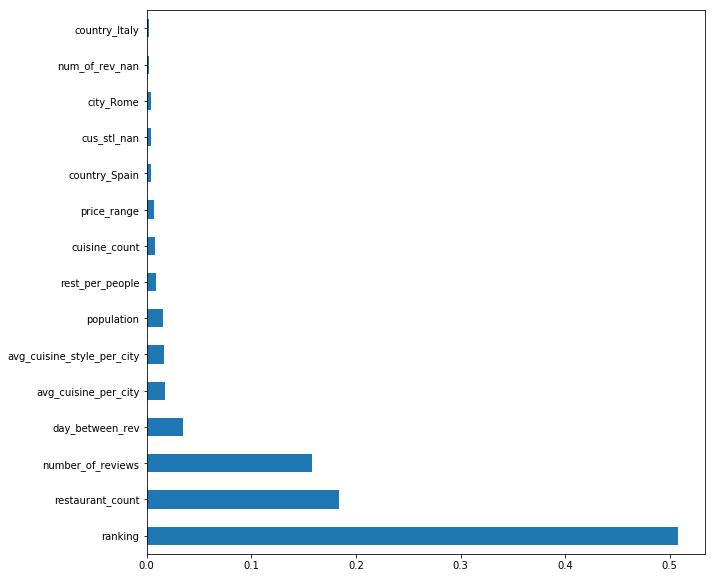

In [36]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# 6. Submission на кагл

In [37]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,num_of_rev_nan,reviews_nan,cus_stl_nan,cuisine_count,avg_cuisine_per_city,avg_cuisine_style_per_city,day_between_rev,country_Austria,country_Belgium,country_Czech Republic,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Schotland,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,country_nan,population,restaurant_count,rest_per_people,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
7518,847.0,100,111.0,0.0,0,0,0,3,2.502283,1.198905,160.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1019022,1314,0.001289,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3407,1497.0,10,62.0,0.0,0,0,0,2,2.742897,0.729156,21.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1691468,1443,0.000853,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5352,2940.0,10,4.0,0.0,0,0,0,4,2.276525,1.757064,11.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3426354,2705,0.000789,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1478,848.0,100,2.0,0.0,0,0,0,2,3.138989,0.637148,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,755050,554,0.000734,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5821,10770.0,100,2.0,0.0,0,0,0,1,2.141945,0.466865,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2138551,6108,0.002856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1878,7468.0,100,9.0,0.0,0,0,1,1,2.679234,0.373241,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1621537,3395,0.002094,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3787,6477.0,100,356.0,0.0,0,0,0,3,2.679234,1.119723,18.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1621537,3395,0.002094,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4079,5735.0,100,0.0,0.0,1,0,1,1,2.679234,0.373241,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1621537,3395,0.002094,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1944,14275.0,100,9.0,0.0,0,0,1,1,2.969137,0.336798,318.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7556900,7193,0.000952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6667,18.0,100,262.0,0.0,0,0,0,6,2.741445,2.188627,40.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,76684,263,0.003430,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
test_data = test_data.drop(['rating'], axis=1)

In [39]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [40]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [41]:
predict_submission

array([2.99 , 4.2  , 4.44 , ..., 3.015, 4.5  , 4.125])

In [42]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.990
1,id_1,4.200
2,id_2,4.440
3,id_3,4.260
4,id_4,4.415
5,id_5,4.460
6,id_6,1.845
7,id_7,2.430
8,id_8,4.065
9,id_9,4.695
